In [136]:
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [137]:
df = pd.read_csv('BBC News Train.csv')
# test_df = pd.read_csv('BBC News Test.csv') - Not sure this works for us because it isn't labeled


In [138]:
# remove stop words from Text
stop_words = set(stopwords.words("english"))
df["Text"] = df["Text"].apply(
    lambda x: " ".join([word for word in x.split() if word.lower() not in stop_words])
)

In [139]:
categories = list(df["Category"].unique())

## Borrowed from week 2 lab
def accuracy_score(y_true, y_pred):
    """
    Calculate accuracy score.
    y_true: true labels
    y_pred: predicted labels
    Returns accuracy as a float.
    """
    return np.mean(y_true == y_pred)


# permutate topics to see which ones go with which categories
def label_permute_compare(ytdf, yp, n=5):
    """
    ytdf: labels dataframe object
    yp: nmf label prediction output
    Returns permuted label order and accuracy.
    Example output: (3, 4, 1, 2, 0), 0.74
    """
    perms = list(itertools.permutations(list(range(n))))
    acc = []
    for i in range(len(perms)):
        mapdict = dict(zip(categories, list(perms[i])))
        yt = ytdf.apply(lambda x: mapdict[x])
        acc.append(accuracy_score(yt, yp))
    idx = np.argmax(acc)
    return perms[idx], acc[idx]

In [140]:
# Convert to TF-IDF
n_features = 1000
n_top_words = 20
n_topics = 5

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df["Text"], df["Category"], test_size=0.2, random_state=42
)

vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
tfidf = vectorizer.fit_transform(X_train)
print(vectorizer.transform(X_train).shape)

(1192, 1000)


In [141]:
nmf = NMF(n_components=n_topics, random_state=1).fit(tfidf)

# feature_names = vectorizer.get_feature_names_out()
# for topic_idx, topic in enumerate(nmf.components_):
#     print("Topic #%d:" % topic_idx)
#     print(" ".join([feature_names[i]
#                     for i in topic.argsort()[:-n_top_words - 1:-1]]))
#     print()
# Get labels and accuracy for train_y

labels, train_acc = label_permute_compare(
    y_train, nmf.transform(vectorizer.transform(X_train)).argmax(axis=1), n_topics
)
print(f"Labels: {labels}, Accuracy: {train_acc:.2f}")
reordered_categories = [categories[i] for i in labels]
print(f"Reordered categories: {reordered_categories}")

Labels: (4, 0, 3, 1, 2), Accuracy: 0.89
Reordered categories: ['entertainment', 'business', 'sport', 'tech', 'politics']


Accuracy: 0.89


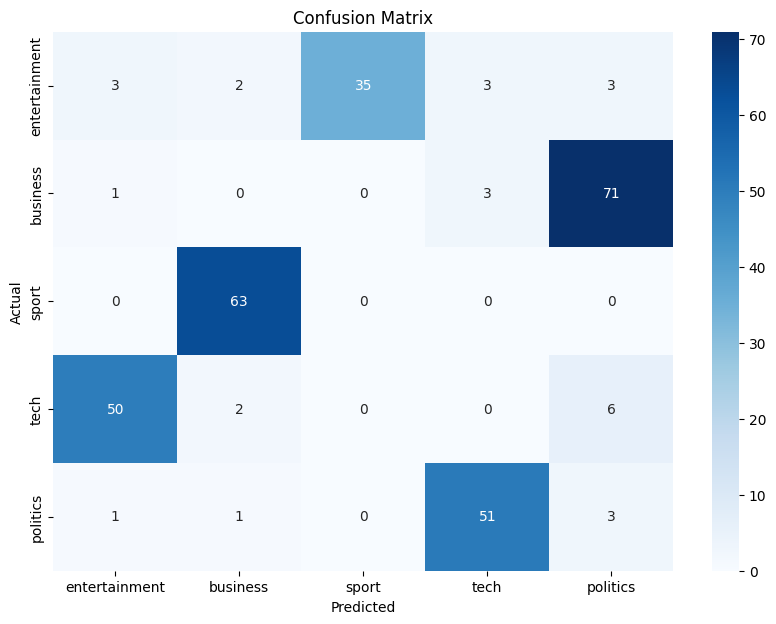

In [142]:
# test the model on the test set
tfidf_test = vectorizer.transform(X_test)

# compare to test_y
predicted_topics = nmf.transform(tfidf_test)
yp = predicted_topics.argmax(axis=1)
labels, test_acc = label_permute_compare(
    y_train, nmf.transform(vectorizer.transform(X_train)).argmax(axis=1), n_topics
)
print(f"Accuracy: {train_acc:.2f}")
reordered_categories = [categories[i] for i in labels]
# Accuracy of test set
# labeldict = dict(zip(reordered_categories, labels))
# test_acc = accuracy_score(
#     y_test.apply(lambda x: labeldict[x]), yp
# )
# print(f"Test Accuracy: {test_acc:.2f}")
# Print Decision Matrix
cm = confusion_matrix(y_test.apply(lambda x: reordered_categories.index(x)), yp)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=reordered_categories, yticklabels=reordered_categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Optimum Hyperparameters

Loop through 3 different hyperparameters and identify which combination provides the best accuracy.

In [ ]:
# Try different types of max_df and min_df and compare the accuracies
def evaluate_tfidf_params(max_df, min_df, n_features, train_x, test_x, train_y, test_y):
    vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, max_features=n_features,
                                 stop_words='english')
    tfidf = vectorizer.fit_transform(train_x)
    nmf = NMF(n_components=n_topics, random_state=1).fit(tfidf)
    
    labels, train_acc = label_permute_compare(train_y, nmf.transform(vectorizer.transform(train_x)).argmax(axis=1), n_topics)
    label_map = dict(zip(categories, labels))
    
    tfidf_test = vectorizer.transform(test_x)
    predicted_topics = nmf.transform(tfidf_test)
    yp = predicted_topics.argmax(axis=1)
    
    test_acc = accuracy_score(test_y.apply(lambda x: label_map[x]), yp)
    
    return train_acc, test_acc
# Example usage of evaluate_tfidf_params
max_dfs = [0.99, 0.95, 0.9, 0.85, .8]
min_dfs = [2, 3, 4, 10, 20]
features_array = [250, 500, 1000, 1500, 2000, 2500]
acc = 0

# Make a table of the accuracies for all permutations of max_df, min_df, and n_features
results = []
best_accuracy = 0
best_params = None
for max_df in max_dfs:
    for min_df in min_dfs:
        for n_features in features_array:
            train_acc, test_acc = evaluate_tfidf_params(max_df=max_df, min_df=min_df, n_features=n_features, train_x=X_train, test_x=X_test, train_y=y_train, test_y=y_test)
            
            if test_acc > best_accuracy:
                best_accuracy = test_acc
                best_params = (max_df, min_df, n_features)
            results.append({
                'max_df': max_df,
                'min_df': min_df,
                'n_features': n_features,
                'train_accuracy': train_acc,
                'test_accuracy': test_acc
            })
results_df = pd.DataFrame(results)
# Save the results to a CSV file
results_df.to_csv('tfidf_results.csv', index=False)
# Print the results DataFrame
print(best_params)

(0.8, 4, 1500)


In [ ]:
# I didn't quite figure out how to use Word2Vec with NMF, so I will leave this commented out for now.
# One thing I noticed was that the Word2Vec model returned negative values, which NMF does not accept.
# I tried to set negative values to zeroes, but it didn't work well with NMF.
# The shape of the Word2Vec vectors was also different from the TF-IDF vectors, which made it difficult to use NMF directly.

# # Try out word2vec instead of TF-IDF
# from gensim.models import Word2Vec
# # Create a Word2Vec model
# word2vec_model = Word2Vec(sentences=X_train, vector_size=100, window=5, min_count=1, workers=4)
# print(X_train.shape)
# # Use NMF to find topics just like before
# # Split the data into training and test sets
# # Fit NMF on the Word2Vec features
# w2v_vectors = word2vec_model.wv.vectors
# print(w2v_vectors.shape)
# # Set negative values to zeroes
# w2v_vectors[w2v_vectors < 0] = 0
# print(w2v_vectors.shape)
# nmf_w2v = NMF(n_components=n_topics, random_state=1).fit(w2v_vectors)
# print(nmf_w2v.components_.shape)
# # Get labels and accuracy for train_y using Word2Vec features
# labels_w2v, train_acc_w2v = label_permute_compare(y_train, nmf_w2v.transform(w2v_vectors).argmax(axis=1), n_topics)
# print(f'Train accuracy with Word2Vec: {train_acc_w2v:.2f}')
# # Predict topics for the test set using Word2Vec features

In [152]:
# lemmatize the text from the TFIDF section and run it through again
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

lemmatized_text = df['Text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

X_train, X_test, y_train, y_test = train_test_split(lemmatized_text, df['Category'], test_size=0.2, random_state=42)

best_accuracy = 0
best_params = None
for max_df in max_dfs:
    for min_df in min_dfs:
        for n_features in features_array:
            train_acc, test_acc = evaluate_tfidf_params(max_df=max_df, min_df=min_df, n_features=n_features)
            if test_acc > best_accuracy:
                best_accuracy = test_acc
                best_params = (max_df, min_df, n_features)
# Save the results to a CSV file
# Print the results DataFrame
print(best_params)

(0.99, 10, 2000)


In [153]:
# bigram the text and then run tfidf
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(X_train)
bigrams_train = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
print(bigrams_train.shape)

(1192, 181629)
